# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [3]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [5]:
train_npz = np.load('../data/train.npz')
train_data = train_npz['data']
test_npz  = np.load('../data/test_input.npz')
test_data  = test_npz['data']

In [6]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [7]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [8]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

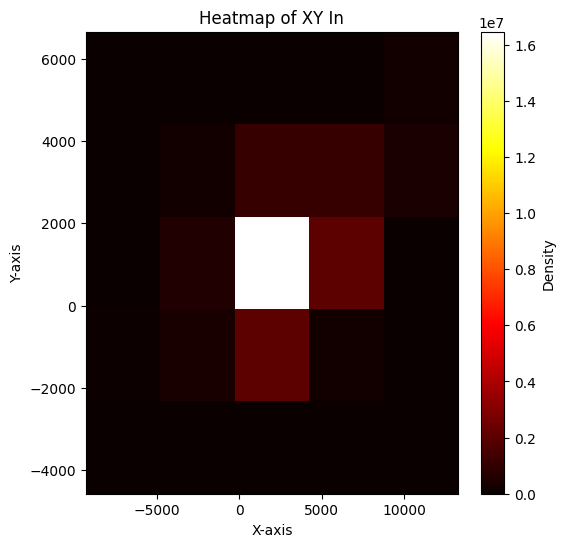

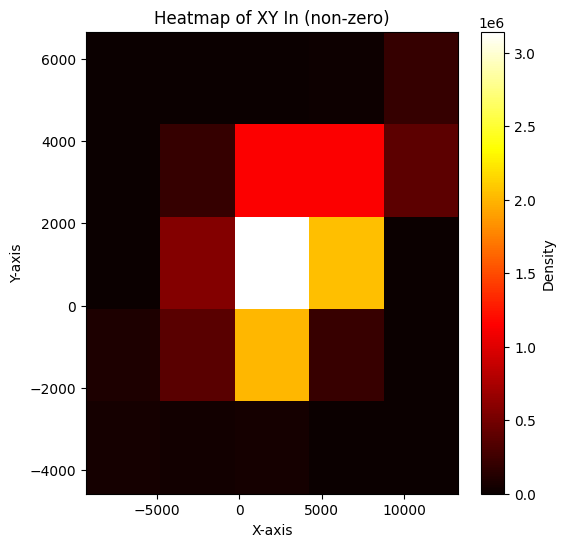

In [9]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

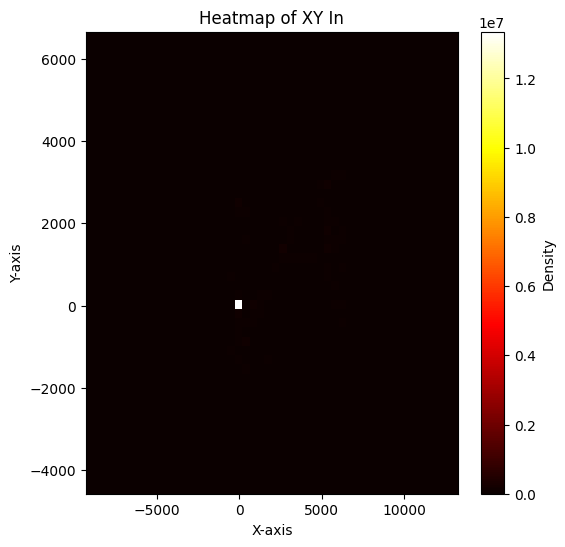

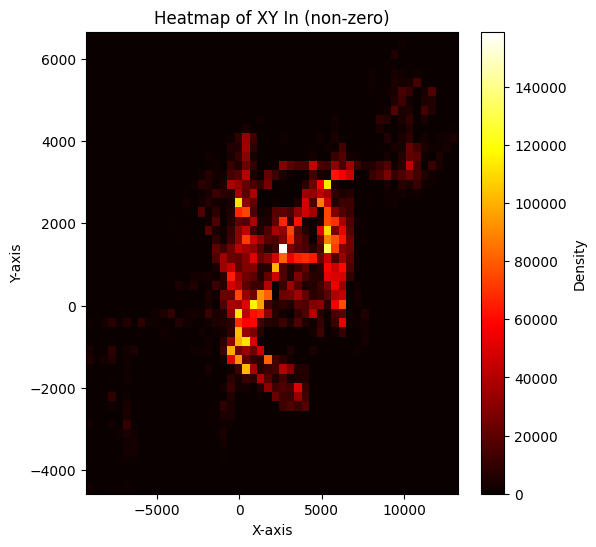

In [10]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [11]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [18]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [19]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [20]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [22]:
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
model = LSTM().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
early_stopping_patience = 10
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [23]:
for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    scheduler.step()
    # scheduler.step(val_loss)
    
    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/yw/9v4l5gqd22j157_8w1xhpc080000gn/T/ipykernel_48947/3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/yw/9v4l5gqd22j157_8w1xhpc080000gn/T/ipykernel_48947/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   1%|          | 1/100 [00:09<15:52,  9.62s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.7640 | val normalized MSE   0.5156, | val MAE   2.7343 | val MSE  25.2621


Epoch:   2%|▏         | 2/100 [00:19<15:29,  9.49s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.4647 | val normalized MSE   0.3859, | val MAE   2.2551 | val MSE  18.9069


Epoch:   3%|▎         | 3/100 [00:29<15:44,  9.74s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.3919 | val normalized MSE   0.3565, | val MAE   2.1717 | val MSE  17.4661


Epoch:   4%|▍         | 4/100 [00:39<15:46,  9.86s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.3617 | val normalized MSE   0.3433, | val MAE   2.1679 | val MSE  16.8220


Epoch:   5%|▌         | 5/100 [00:48<15:23,  9.72s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.3474 | val normalized MSE   0.3349, | val MAE   2.1379 | val MSE  16.4086


Epoch:   6%|▌         | 6/100 [00:57<15:01,  9.59s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.3275 | val normalized MSE   0.3067, | val MAE   2.0281 | val MSE  15.0264


Epoch:   7%|▋         | 7/100 [01:08<15:35, 10.06s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.3124 | val normalized MSE   0.2791, | val MAE   1.8191 | val MSE  13.6753


Epoch:   8%|▊         | 8/100 [01:19<15:39, 10.22s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2961 | val normalized MSE   0.2851, | val MAE   1.8758 | val MSE  13.9705


Epoch:   9%|▉         | 9/100 [01:29<15:14, 10.05s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2894 | val normalized MSE   0.2649, | val MAE   1.8437 | val MSE  12.9783


Epoch:  10%|█         | 10/100 [01:38<14:46,  9.85s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2759 | val normalized MSE   0.2516, | val MAE   1.7939 | val MSE  12.3293


Epoch:  11%|█         | 11/100 [01:47<14:23,  9.70s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2699 | val normalized MSE   0.2416, | val MAE   1.7457 | val MSE  11.8406


Epoch:  12%|█▏        | 12/100 [01:57<14:08,  9.64s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2603 | val normalized MSE   0.2508, | val MAE   1.8092 | val MSE  12.2905


Epoch:  13%|█▎        | 13/100 [02:07<14:01,  9.67s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2535 | val normalized MSE   0.2353, | val MAE   1.6859 | val MSE  11.5285


Epoch:  14%|█▍        | 14/100 [02:17<14:01,  9.78s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2484 | val normalized MSE   0.2226, | val MAE   1.7099 | val MSE  10.9071


Epoch:  15%|█▌        | 15/100 [02:27<14:03,  9.93s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2444 | val normalized MSE   0.2154, | val MAE   1.6179 | val MSE  10.5538


Epoch:  16%|█▌        | 16/100 [02:37<13:54,  9.93s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2391 | val normalized MSE   0.2317, | val MAE   1.7238 | val MSE  11.3548


Epoch:  17%|█▋        | 17/100 [02:47<13:51, 10.01s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2373 | val normalized MSE   0.2200, | val MAE   1.7488 | val MSE  10.7815


Epoch:  18%|█▊        | 18/100 [02:57<13:29,  9.87s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2353 | val normalized MSE   0.2133, | val MAE   1.5910 | val MSE  10.4532


Epoch:  19%|█▉        | 19/100 [03:07<13:20,  9.89s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2298 | val normalized MSE   0.2151, | val MAE   1.5833 | val MSE  10.5385


Epoch:  20%|██        | 20/100 [03:16<13:01,  9.77s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2298 | val normalized MSE   0.2264, | val MAE   1.7209 | val MSE  11.0953


Epoch:  21%|██        | 21/100 [03:26<12:46,  9.70s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2096 | val normalized MSE   0.1966, | val MAE   1.4409 | val MSE   9.6320


Epoch:  22%|██▏       | 22/100 [03:35<12:30,  9.62s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.2059 | val normalized MSE   0.2001, | val MAE   1.5329 | val MSE   9.8048


Epoch:  23%|██▎       | 23/100 [03:45<12:25,  9.68s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.2042 | val normalized MSE   0.1980, | val MAE   1.4503 | val MSE   9.7024


Epoch:  24%|██▍       | 24/100 [03:54<12:13,  9.65s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.2017 | val normalized MSE   0.1955, | val MAE   1.4507 | val MSE   9.5791


Epoch:  25%|██▌       | 25/100 [04:04<12:04,  9.66s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.2011 | val normalized MSE   0.1986, | val MAE   1.4547 | val MSE   9.7315


Epoch:  26%|██▌       | 26/100 [04:14<11:56,  9.69s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.2017 | val normalized MSE   0.1997, | val MAE   1.4750 | val MSE   9.7855


Epoch:  27%|██▋       | 27/100 [04:23<11:45,  9.66s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.2016 | val normalized MSE   0.1990, | val MAE   1.4974 | val MSE   9.7487


Epoch:  28%|██▊       | 28/100 [04:33<11:32,  9.61s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.1999 | val normalized MSE   0.1985, | val MAE   1.5205 | val MSE   9.7265


Epoch:  29%|██▉       | 29/100 [04:42<11:18,  9.56s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.1999 | val normalized MSE   0.1970, | val MAE   1.5045 | val MSE   9.6542


Epoch:  30%|███       | 30/100 [04:52<11:19,  9.70s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.1999 | val normalized MSE   0.1950, | val MAE   1.5256 | val MSE   9.5568


Epoch:  31%|███       | 31/100 [05:02<11:03,  9.62s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.1985 | val normalized MSE   0.2042, | val MAE   1.5275 | val MSE  10.0060


Epoch:  32%|███▏      | 32/100 [05:11<10:48,  9.53s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.1976 | val normalized MSE   0.1915, | val MAE   1.4675 | val MSE   9.3850


Epoch:  33%|███▎      | 33/100 [05:21<10:34,  9.47s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.1977 | val normalized MSE   0.1952, | val MAE   1.5143 | val MSE   9.5629


Epoch:  34%|███▍      | 34/100 [05:30<10:22,  9.44s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.1958 | val normalized MSE   0.1976, | val MAE   1.5261 | val MSE   9.6837


Epoch:  35%|███▌      | 35/100 [05:39<10:11,  9.40s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.1963 | val normalized MSE   0.1890, | val MAE   1.4668 | val MSE   9.2609


Epoch:  36%|███▌      | 36/100 [05:49<10:00,  9.38s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.1952 | val normalized MSE   0.1956, | val MAE   1.4569 | val MSE   9.5836


Epoch:  37%|███▋      | 37/100 [05:58<09:50,  9.38s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.1963 | val normalized MSE   0.1971, | val MAE   1.5016 | val MSE   9.6587


Epoch:  38%|███▊      | 38/100 [06:07<09:40,  9.37s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.1948 | val normalized MSE   0.1929, | val MAE   1.4872 | val MSE   9.4503


Epoch:  39%|███▉      | 39/100 [06:17<09:31,  9.37s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.1934 | val normalized MSE   0.1920, | val MAE   1.4718 | val MSE   9.4098


Epoch:  40%|████      | 40/100 [06:26<09:21,  9.35s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.1942 | val normalized MSE   0.1939, | val MAE   1.4501 | val MSE   9.5034


Epoch:  41%|████      | 41/100 [06:35<09:11,  9.35s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1870 | val normalized MSE   0.1901, | val MAE   1.4340 | val MSE   9.3138


Epoch:  42%|████▏     | 42/100 [06:45<09:02,  9.36s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1863 | val normalized MSE   0.1891, | val MAE   1.4158 | val MSE   9.2641


Epoch:  43%|████▎     | 43/100 [06:54<08:53,  9.37s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1863 | val normalized MSE   0.1873, | val MAE   1.4348 | val MSE   9.1769


Epoch:  44%|████▍     | 44/100 [07:03<08:44,  9.37s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1852 | val normalized MSE   0.1884, | val MAE   1.4159 | val MSE   9.2325


Epoch:  45%|████▌     | 45/100 [07:13<08:35,  9.37s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1853 | val normalized MSE   0.1902, | val MAE   1.4555 | val MSE   9.3198


Epoch:  46%|████▌     | 46/100 [07:22<08:25,  9.37s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1841 | val normalized MSE   0.1868, | val MAE   1.4022 | val MSE   9.1543


Epoch:  47%|████▋     | 47/100 [07:32<08:20,  9.44s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1856 | val normalized MSE   0.1857, | val MAE   1.4012 | val MSE   9.1013


Epoch:  48%|████▊     | 48/100 [07:41<08:10,  9.43s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1842 | val normalized MSE   0.1869, | val MAE   1.4048 | val MSE   9.1562


Epoch:  49%|████▉     | 49/100 [07:51<08:00,  9.42s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1842 | val normalized MSE   0.1893, | val MAE   1.4414 | val MSE   9.2750


Epoch:  50%|█████     | 50/100 [08:00<07:49,  9.39s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1837 | val normalized MSE   0.1854, | val MAE   1.4139 | val MSE   9.0864


Epoch:  51%|█████     | 51/100 [08:09<07:40,  9.40s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1841 | val normalized MSE   0.1867, | val MAE   1.3968 | val MSE   9.1498


Epoch:  52%|█████▏    | 52/100 [08:19<07:30,  9.38s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1837 | val normalized MSE   0.1858, | val MAE   1.4203 | val MSE   9.1020


Epoch:  53%|█████▎    | 53/100 [08:28<07:23,  9.44s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1842 | val normalized MSE   0.1866, | val MAE   1.4187 | val MSE   9.1453


Epoch:  54%|█████▍    | 54/100 [08:38<07:13,  9.42s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1831 | val normalized MSE   0.1869, | val MAE   1.4403 | val MSE   9.1560


Epoch:  55%|█████▌    | 55/100 [08:47<07:02,  9.39s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1829 | val normalized MSE   0.1873, | val MAE   1.4333 | val MSE   9.1780


Epoch:  56%|█████▌    | 56/100 [08:56<06:52,  9.37s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1831 | val normalized MSE   0.1863, | val MAE   1.3990 | val MSE   9.1292


Epoch:  56%|█████▌    | 56/100 [09:06<07:09,  9.76s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1823 | val normalized MSE   0.1875, | val MAE   1.4277 | val MSE   9.1871
Early stop!


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [24]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

/var/folders/yw/9v4l5gqd22j157_8w1xhpc080000gn/T/ipykernel_48947/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin


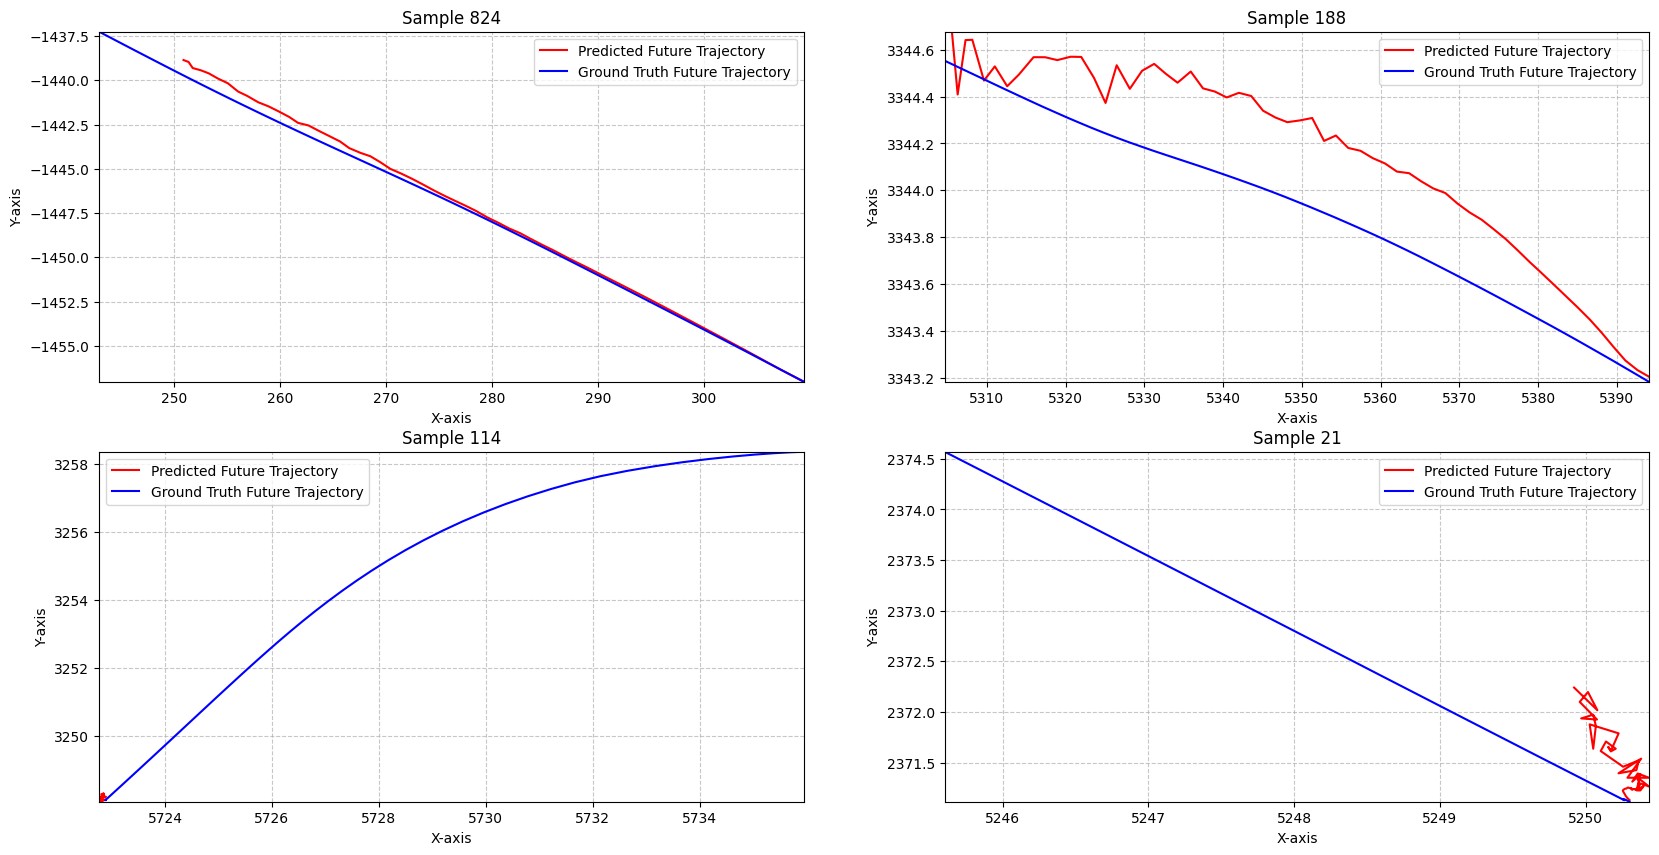

In [25]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [26]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
model = LSTM().to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
# output_df.to_csv('submission.csv', index=True)

NameError: name 'pd' is not defined

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B